2D Parcels Test Model (depth and lon) - Matt

# Load packages and functions

In [1]:
%matplotlib inline
import parcels
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, StatusCode, ParcelsRandom
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime, timedelta
import os
import mocsy
from salishsea_tools import nc_tools, visualisations
from glob import glob

from IPython.display import Image
rc('animation', html='html5')

# Define model parameters

In [39]:
# Iteration name (for output file)
iteration_name = 'iteration_2'

# Choose hour, date, and location to grab vertical eddy diffusivity values from
hour = 0 
year = 2018
month = 8
day = 1
lat = 49.224563 
lon = -123.605357

# Choose the number of particles to be released
N = 100 #10e3

# Choose pteropod behaviour parameters
swim = -30e-3 # m/s (initial = 32.5e-3) (negative value because swimming upwards DECREASES the particle's depth)
sink = 40e-3 # m/s (initial = 20e-3) the sinking speed should exceed the swimming speed. the random direction change switches them between swimming and sinking, and the 1.05 means they are swimming 5% more often than sinking
feed_dt = 9 * 60 # feeding time before choosing new behaviour (in seconds), must be greater than outputdt and a multiple of outputdt
swim_dt = 3 * 60 # swimming or sinking time before choosing new behaviour (in seconds), must be greater than outputdt and a multiple of outputdt

# Choose reference pteropod vertical distribution (from my vertical distribution study)
vertical_dist = [0.370, 0.313, 0.144, 0.074, 0.040, 0.040, 0.019] # bin means from all day and night LimS0 standard interval tows
xerr = [0.090, 0.087, 0.053, 0.034, 0.017, 0.030, 0.017] # 95% confidence intervals for the means from all day and night LimS0 standard interval tows (n = 38)

# Define the output file
outputdt = 1.5 * 60 # how often do you want parcels to write output? (in seconds)
outputpath = '/ocean/mattmiller/MOAD/analysis-matt/notebooks/2D_model_iterations/'+iteration_name+'/'+iteration_name+'.zarr' # this makes sure the results are saved in the folder of this iteration
runtime = timedelta(hours=6) # the total length of the run
dt = 1.5 * 60 # the particle timestep (in seconds)
print(outputpath)

/ocean/mattmiller/MOAD/analysis-matt/notebooks/2D_model_iterations/iteration_2/iteration_2.zarr


# Build parcels particle simulation

## Step 1: Define parcels FieldSet

In [3]:
# Get SalishSeaCast grid index for chosen lat longs to pull vertical eddy diffusivity profile from
# j is the index along the SalishSeaCast grid (think y axis of model domain, or similar to latitude), while i is the index across the grid
jjii = xr.open_dataset('/home/sallen/MEOPAR/grid/grid_from_lat_lon_mask999.nc') # This is a file that gives the closest SalishSeaCast grid point (i and j) for a given lat and lon 
j = [jjii.jj.sel(lats=lat, lons=lon, method='nearest').item()][0] # get the j index value that is closets to the chosen lat/lon coordinate (between 0-897)
i = [jjii.ii.sel(lats=lat, lons=lon, method='nearest').item()][0] # get the j index value that is closets to the chosen lat/lon coordinate (between 0-397)
mbathy = xr.open_dataset("/home/sallen/MEOPAR/grid/mesh_mask202108.nc").mbathy[0,j,i].item() # This saves the index of the deepest grid cell at the chosen horizontal grid cell (j,i coordinates)
print(j,i, mbathy)

472 263 37


In [4]:
# Define filepath to pull SalishSeaCast results
path_NEMO = nc_tools.get_hindcast_prefix(date = datetime(year, month, day), res = 'h', version = '201905')
print(path_NEMO)

/results2/SalishSea/nowcast-green.201905/01aug18/SalishSea_1h_20180801_20180801


In [5]:
# Load W grid data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False) # Opens the W grid data from SSC (vertical velocity grid but includes vertical eddy diffusivity)
depth = np.array(Wdat.depthw[:mbathy+1]).astype('float32') # this makes a list of the depth values of the grid cells from the first index to the index of mbathy + 1 (40 vertical grid cells in SSC but at this location there are only 37 and it includes the last because that represents the start of the next grid cell which would actually be the bottom?)
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy+1,j,i]).astype('float32') # This extracts the vertical_eddy_diffusivity values from Wdat for the chosen range of vertical grid cells, at the chosen hour and horizontal grid cell (j,i coordinates)

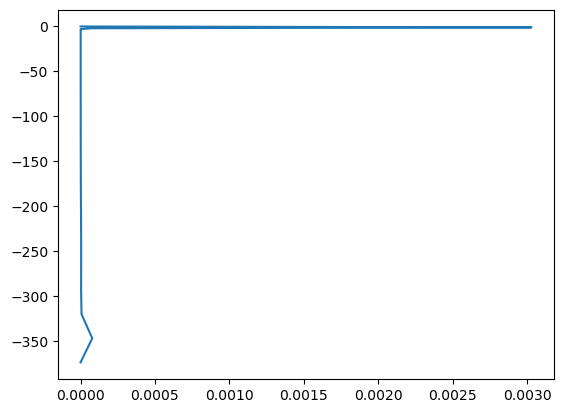

In [6]:
# Plot depth profile of vertical eddy diffusivity
plt.plot(Kz_col,-depth)

In [6]:
# Add field for DIC, TA, S, etc. to fieldset to later calculate OmegaA experienced by the particles
Tdat = xr.open_dataset(path_NEMO+'_grid_T.nc', decode_times=False) # Opens the T grid data from SSC (temperature and salinity)
depth2 = np.array(Tdat.deptht[:mbathy+1]).astype('float32') # grabs depths of vertical grid cells - note that T variables are on different nodes on grid cells than U, V, W, so depths are slightly different
Temp_col = np.array(Tdat.votemper[hour,:mbathy+1,j,i]).astype('float32') # Extract temperature values from Tdat for chosen range of vertical grid cells, at chosen hour and horizontal grid cell (j,i coordinates)

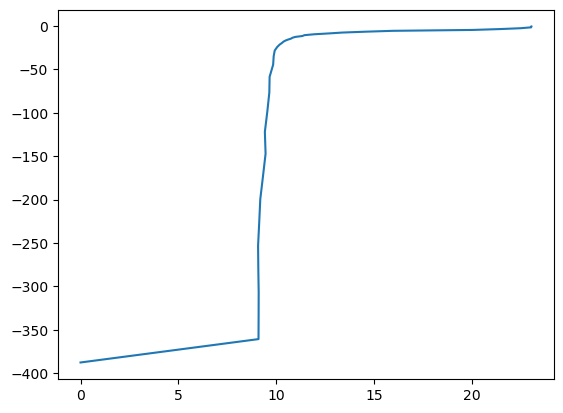

In [8]:
# Plot depth profile of temperature
plt.plot(Temp_col,-depth2)

In [7]:
# Define domain, velocity fields and Kz 
dim = 100 # length of fake longitude values for the 2D simulation
dep = len(depth) # length of the list of vertical grid cells at the chosen location for the 2D simulation
lon = np.linspace(0., 2e3, dim, dtype=np.float32) # creates a 1D array (a list) of 100 fake longitude values from 0 to 2000

# Build fieldsets for OceanParcels
# in parcels, 'U' represents the zonal flow velocity (zonal = east-to-west/west-to-east), and 'V' represents the meridional flow velocity (meridional = north-to-south/south-to-north)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # creates a fake parcels.Field object for the U field, filled with zeros (horizontal velocity = 0), with the dimensions = (dep, dim), so here thats 38 x 100
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # creates a fake parcels.Field object for the V field, filled with zeros (horizontal velocity = 0), with the dimensions = (dep, dim), so here thats 38 x 100

Kz_data = np.zeros((dep, dim), dtype=np.float32) # creates an array filled with zeros the shape = (dep, dim), so here thats 38 x 100

for i in range(dim): # loop, from i = 0 to 100
    Kz_data[:,i]=Kz_col   # this assigns the list of 38 Kz values (1 for each vertical grid cell) to each of the 100 fake longitude values

Kz = Field('Kz', Kz_data, grid=U.grid) # this creates a parcels.Field object out of the Kz data array you just created

Temp_data = np.zeros((dep, dim), dtype=np.float32)

for i in range(dim): 
    Temp_data[:,i]=Temp_col 

T = Field('T', Temp_data, grid=U.grid)

fieldset = FieldSet(U,V) # creates a fieldset with your fake U and V grids with zero volocity
fieldset.add_field(Kz) # adds your custom Kz field to the fieldset
fieldset.add_field(T)
fieldset.swim = swim
fieldset.sink = sink
fieldset.feed_dt = feed_dt
fieldset.swim_dt = swim_dt
# You now have a functional custom parcels fieldset to run particles in

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/parcels/grid.py:88: RuntimeWarning: All-NaN slice encountered
  [np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], dtype=np.float32


## Step 2: Define parcels ParticleSet

additional Variables can be added to the particles (e.g. temperature, to keep track of the temperature that particles experience).

In [8]:
# Define a new particleclass with specified variables to keep track of
class Particle(parcels.JITParticle):
    age = Variable('age', dtype = np.float32, initial =  0.0) # add a variable to keep track of the particle's age - might not need this for final model
    temperature = Variable('temperature', dtype=np.float32) # add temperature variable
    Kh = Variable('Kh', dtype = np.float32, initial =  0.0, to_write = 'once') # this adds the variable kh which is horizontal eddy diffusivity, and sets it to be 0 - in this simulation I'm only using kz (vertical eddy diffusivity)
    bath = Variable('bath', dtype = np.float32, initial = depth[-1]) # this adds the variable bath which is the particle's bathymetry; basically it keeps track of what the bottom depth is for a given particle
    movement = Variable('movement', dtype = np.int8, initial = 0) # particle.movement variable to keep track of the particle's current behaviour (-1, 0, 1), updated at each dt by swim_kernel
    movementdt = Variable('movementdt', np.float32, initial = 0.0)
# I dont think this bathymetry variable method will work in the 3D model b/c now the bathymetry is the same for the whole 2D test model and it only samples the final value of the 1D array 'depth'
# Or youd have to write a sample_bath kernel probably, and define this prticle variable differently here

# Set the release coordinates: start with random distribution of N number of particles
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(int(N),))
depth_g = np.random.uniform(low=depth[0], high=250, size=(int(N),)) # release particles at random depths down to 250 m. If you want to the bottom, replace 250 with depth[-1]
lat_g = np.zeros(int(N),)

# Define the particle set using the particle class you just created
pset = parcels.ParticleSet(
    fieldset=fieldset,  # the fields that the particleset uses
    pclass=Particle,  # define the class of particle
    lon=lon_g,  # release longitude
    lat=lat_g,  # release latitude
    depth = depth_g # release depth
) 

## Step 3: Define parcels particle kernels

In [9]:
# Create a custom kernel which keeps track of the particle age (minutes)
def age_kernel(particle, fieldset, time):
    particle.age += particle.dt / 3600

# Create a custom kernel which keeps track of the particle temperature
def SampleTemp(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

In [31]:
# Mixing Kernel - Uses a gradient in Kz between two depths for more precise depth-dependance of diffusivity, inlcudes well-mixed boundary layers, and includes horizontal mixing (Kh) but here it is set to 0.
def mix_kernel(particle,fieldset,time): 
    if particle.depth + 1 > particle.bath: #Forward euler
        Kzdz = (fieldset.Kz[time, particle.depth, particle.lat, particle.lon] - fieldset.Kz[time, particle.depth - 1, particle.lat, particle.lon]) #forward difference 
    else:
        Kzdz = (fieldset.Kz[time, particle.depth + 1, particle.lat, particle.lon] - fieldset.Kz[time, particle.depth, particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth + 0.5 * dgrad > 0 and particle.depth + 0.5 * dgrad < particle.bath:
        kk = fieldset.Kz[time, particle.depth + 0.5 * dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, particle.bath, particle.lat, particle.lon] #Vertical diffusivity SSC 
    Kx = particle.Kh # horizontal diffusion (has been set to 0 when defining the particle class)
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = math.sqrt(3 * 2 * kk * particle.dt) * Rr
    d_randomx = math.sqrt(3 * 2 * Kx * particle.dt) * Rr2
    Dlayerz = 0.5 * math.sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5 * math.sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon = particle.lon + d_randomx
    if d_random + dgrad + particle.depth > particle.bath: #randomly in boundary mixed layer
        particle.depth = particle.bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random + particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [10]:
# Simpler vertical mixing kernel - does not use a gradient, does not include boundary layers, does not include option for horizontal mixing
def mix_kernel(particle, fieldset, time):
    """Kernel for vertical mixing using the random walk model."""

    # Compute random displacement due to mixing
    if fieldset.Kz[time, particle.depth, particle.lat, particle.lon] > 0:
        random_disp = ParcelsRandom.normalvariate(0, math.sqrt(2 * fieldset.Kz[time, particle.depth, particle.lat, particle.lon] * particle.dt))
        particle_ddepth += random_disp  # Apply displacement to the particle
    # Else no particle displacement

    # Boundary check (ensures particles don't go above surface or below seafloor)
    if particle.depth + particle_ddepth < 0: # if the depth delta would put them above the surface:
        particle_ddepth += 0 - particle.depth - particle_ddepth # then correct the depth delta to put them at the surface boundary (0 m)
    elif particle.depth + particle_ddepth > particle.bath: # if the depth delta would put them deeper than the bottom depth:
        particle_ddepth += particle.bath - particle.depth - particle_ddepth  # then correct the depth delta to put them at the seafloor boundary
    # Else no correction to depth delta is needed

In [ ]:
# Original swimming kernel simplified
def swim_kernel(particle,fieldset,time):
    kappa = fieldset.swim**2 * fieldset.swim_dt 
    eff_swim = math.sqrt(kappa / particle.dt) 
    zswim = (-particle.dt * (fieldset.upward - 1) * fieldset.sink + 
             particle.dt * (eff_swim - fieldset.upward * fieldset.sink) * 
             math.cos(ParcelsRandom.uniform(0, 2 * math.pi))) 
    if particle.depth + zswim < 0: # if the particle's change in depth would put it above the surface, set its depth to 0 m
        particle.depth = 0
    elif particle.depth + zswim > particle.bath: # else if the particle's depth change would put it deeper than the bottom depth, set its depth to be the bottom depth
        particle.depth = particle.bath
    else:
        particle.depth += zswim # else update the the particle's depth as its current depth plus the depth change

In [ ]:
# Swimming Kernel simple, even weights and timesteps
def swim_kernel(particle, fieldset, time):
    # Randomly select movement: -1 (sink), 0 (stay still), 1 (swim up)
    movement = ParcelsRandom.randint(-1, 1)

    # Apply the correct rate based on movement type
    if movement == -1:
        particle_ddepth += fieldset.sink * particle.dt  # Sinking
    elif movement == 1:
        particle_ddepth += fieldset.swim * particle.dt  # Swimming upward
    # If movement == 0, no change in depth (stays still)

    # Boundary check (ensures particles don't go above surface or below seafloor)
    if particle.depth + particle_ddepth < 0: # if the depth delta would put them above the surface:
        particle_ddepth += 0 - particle.depth - particle_ddepth # then correct the depth delta to put them at the surface boundary (0 m)
    elif particle.depth + particle_ddepth > particle.bath: # if the depth delta would put them deeper than the bottom depth:
        particle_ddepth += particle.bath - particle.depth - particle_ddepth  # then correct the depth delta to put them at the seafloor boundary
    # Else no correction to depth delta is needed

In [ ]:
# Swimming Kernel updated - weighted probabilities
def swim_kernel(particle, fieldset, time):

    # Check if movement duration exceeds threshold
    if particle.movement == 0 and (particle.movementdt + particle.dt) > fieldset.feed_dt: # if currently feeding and this particle timestep WOULD put it over the feeding time
        # then randomly choose a new movement behaviour with weighted probabilities:
        r = ParcelsRandom.uniform(0, 1)  # Generate a random float between 0 and 1
        if r < 0.1:
            particle.movement = -1  # 10% chance to sink
        elif r < 0.6:
            particle.movement = 0   # 50% chance to feed
        else:
            particle.movement = 1   # 40% chance to swim
        particle.movementdt = 0 # and reset the movement duration
    
    elif (particle.movement == 1 or particle.movement == -1) and (particle.movementdt + particle.dt) > fieldset.swim_dt: # if currently swimming or sinking and this particle timestep WOULD put it over the swimming time
        # then randomly choose a new movement behaviour with weighted probabilities:
        r = ParcelsRandom.uniform(0, 1)  # Generate a random float between 0 and 1
        if r < 0.1:
            particle.movement = -1  # 10% chance to sink
        elif r < 0.6:
            particle.movement = 0   # 50% chance to feed
        else:
            particle.movement = 1   # 40% chance to swim
        particle.movementdt = 0 # and reset the movement duration
    # else do not update particle.movement or particle.movementdt
    
    # Update vertical movement
    if particle.movement == 1: # Swimming upward
        particle_ddepth += fieldset.swim * particle.dt
    elif particle.movement == -1: # Sinking
        particle_ddepth += fieldset.sink * particle.dt  
    # If particle.movement == 0, no change in depth

    # Update movement duration
    particle.movementdt += particle.dt

    # Boundary check (ensures particles don't go above surface or below seafloor)
    if particle.depth + particle_ddepth < 0: # if the depth delta would put them above the surface:
        particle_ddepth += 0 - particle.depth - particle_ddepth # then correct the depth delta to put them at the surface boundary (0 m)
    elif particle.depth + particle_ddepth > particle.bath: # if the depth delta would put them deeper than the bottom depth:
        particle_ddepth += particle.bath - particle.depth - particle_ddepth  # then correct the depth delta to put them at the seafloor boundary
    # Else no correction to depth delta is needed

# Note: if you want simpler, non-weighted random choice, use ParcelsRandom.randint(-1, 1)

In [12]:
# Delete particle kernel: Delete particle from OceanParcels simulation to avoid run failure if particle goes out of bounds
def delete_particle_kernel(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

In [ ]:
# Write a boundary check kernel? (that ensures particles don't go above surface or below seafloor after all position changes are summed) instead of including the boundary check in the swimming kernel

In [13]:
# define all kernels to be executed on particles using an (ordered) list
kernels = [age_kernel, mix_kernel, swim_kernel, SampleTemp, delete_particle_kernel] # keep delete_particle_kernel at end of kernel list, otherwise later Kernels may overwrite the particle.state or the particle_dlon variables

## Step 4: Execute parcels simulation

In [14]:
output_file = pset.ParticleFile(
    name = outputpath, # output file name
    outputdt = outputdt, # output timestep
    #chunks = (N, 10),  # the chunking of the output file (number of particles, timesteps). It will generally be much more efficient if chunks[0]*chunks[1] is (much) greater than several thousand.
)

pset.execute(
    kernels,  # the list of kernels (which defines how particles move)
    runtime = runtime, # model run time - how can I define these at the start of my code and call them here?
    dt = dt, # model timestep to calculate particle locations
    output_file = output_file,
)

INFO: Output files are stored in /ocean/mattmiller/MOAD/analysis-matt/notebooks/2D_model_iterations/iteration_2/iteration_2.zarr.
100%|██████████| 21600.0/21600.0 [01:38<00:00, 219.34it/s]


# Load results from previous parcels simulations

In [40]:
dat = xr.load_dataset(outputpath)

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [41]:
# View data
print(dat)

<xarray.Dataset> Size: 962kB
Dimensions:      (trajectory: 100, obs: 240)
Coordinates:
  * obs          (obs) int32 960B 0 1 2 3 4 5 6 ... 233 234 235 236 237 238 239
  * trajectory   (trajectory) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    Kh           (trajectory) float32 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    age          (trajectory, obs) float32 96kB 0.025 0.05 0.075 ... 5.975 6.0
    bath         (trajectory, obs) float32 96kB 374.1 374.1 ... 374.1 374.1
    lat          (trajectory, obs) float32 96kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon          (trajectory, obs) float32 96kB 61.8 61.8 ... 1.805e+03
    movement     (trajectory, obs) float32 96kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    movementdt   (trajectory, obs) float32 96kB 90.0 180.0 270.0 ... 90.0 180.0
    temperature  (trajectory, obs) float32 96kB 9.502 9.502 ... 9.445 9.445
    time         (trajectory, obs) timedelta64[ns] 192kB 00:00:00 ... 05:58:30
    z            (trajectory, obs) f

Text(0.5, 0.98, 'swim_sink_feed')

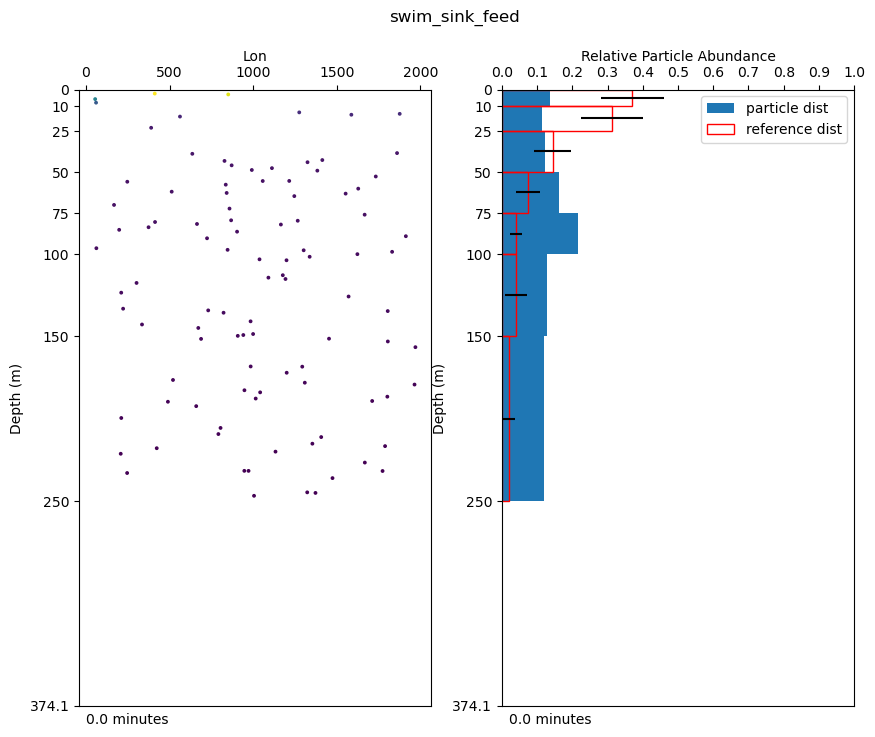

In [42]:
# plot initial timestep
counts, bins = np.histogram(dat.z[:, 0], bins=[0, 10, 25, 50, 75, 100, 150, 250, depth[-1]]) # Calculate the counts and bins for the histogram
bin_edges = [0,  10,  25,  50,  75, 100, 150, 250] # Calculate the bin edges (for placing bins on the y-axis
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
#tstamp = dat.time[0, 0].values.astype('timedelta64[D]').astype(datetime) # Can change [D] to [M] for months *** something to figure out - it cant print in hour increments, only days - how to show like 8 hours?
tstamp = str(dat.time[0, 0].values / np.timedelta64(1, 'm')) + ' minutes'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,0],dat.z[:,0],s=3,c=dat.temperature[:,0]) 
ax1.set_yticks(bins, [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1], 1)]) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, depth[-1]) # 250
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_edges, relative_abundance, label = 'particle dist', height=binwidths, align='edge', color='tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_edges[:7], vertical_dist, label = 'reference dist', height=binwidths[:7], align='edge', color='none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1], 1)]) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, depth[-1]) # 250
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('swim_sink_feed')

Text(0.5, 0.98, 'swim_sink_feed')

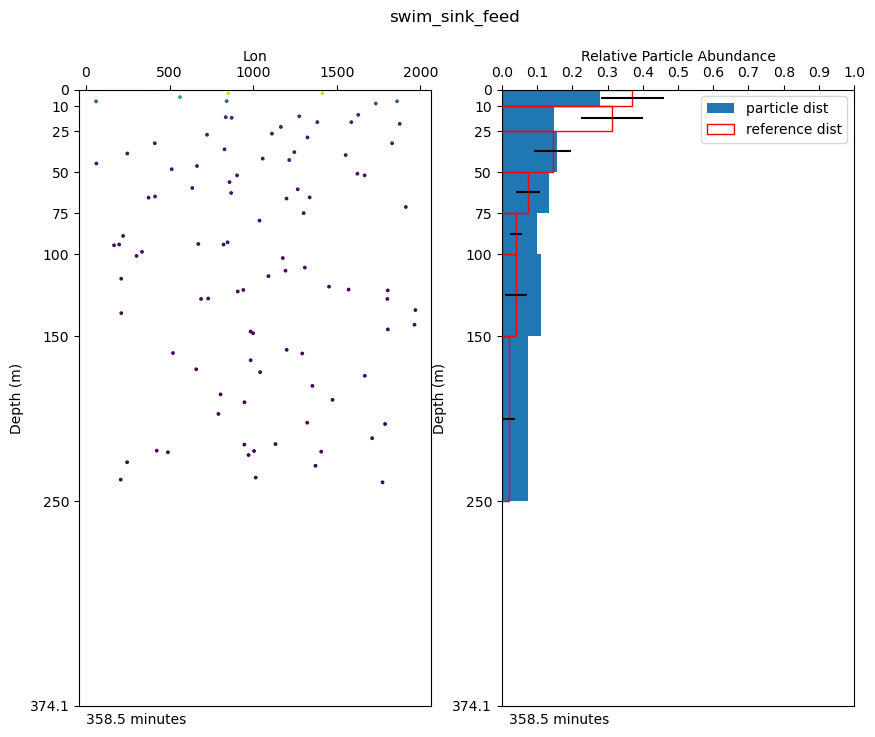

In [43]:
# plot final timestep
counts, bins = np.histogram(dat.z[:, -1], bins=[0, 10, 25, 50, 75, 100, 150, 250, depth[-1]]) # Calculate the counts and bins for the histogram
bin_edges = [0,  10,  25,  50,  75, 100, 150, 250] # Calculate the bin edges (for placing bins on the y-axis)
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
#tstamp = dat.time[0, -1].values.astype('timedelta64[D]').astype(datetime) + timedelta(days=1) # Can change [D] to [M] for months. The + timedelta(days=1) is b/c of python indexing starting days at 0
tstamp = str(dat.time[0, -1].values / np.timedelta64(1, 'm')) + ' minutes'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,-1],dat.z[:,-1],s=3,c=dat.temperature[:,-1])
ax1.set_yticks(bins, [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1], 1)]) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, depth[-1]) #250
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_edges, relative_abundance, label = 'particle dist', height = binwidths, align = 'edge', color = 'tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_edges[:7], vertical_dist, label = 'reference dist', height = binwidths[:7], align = 'edge', color = 'none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1], 1)]) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, depth[-1]) #250
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('swim_sink_feed')

# Animations

In [44]:
def anim(dat,fps=1):  
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
    ax1.set_ylim(0,depth[-1])
    ax1.set_yticks([0, 10, 25, 50, 75, 100, 150, 250, depth[-1]], [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1])]) # Set the tick positions and labels for the y-axis
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('Lon')
    ax1.set_ylabel('Depth (m)')
    ax2.set_ylim(0,depth[-1])
    ax2.invert_yaxis()
    ax2.set_yticks([0, 10, 25, 50, 75, 100, 150, 250, depth[-1]], [0, 10, 25, 50, 75, 100, 150, 250, round(depth[-1])]) # Set the tick positions and labels for the y-axis
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
    ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
    ax2.set_ylabel('Depth (m)')
    plt.suptitle('swim_sink_feed')

    bin_edges = [0,  10,  25,  50,  75, 100, 150, 250] # Calculate the bin centers (for placing bins on the y-axis)
    binwidths = np.diff([0, 10, 25, 50, 75, 100, 150, 250, depth[-1]]) # Define the binwidths

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]        
        ss.append(ax1.scatter(dat.lon[:,frame],dat.z[:,frame],s=3,c=dat.temperature[:,frame])) 
        #tstamp = dat.time[0, frame].values.astype('timedelta64[ns]').astype(datetime)
        tstamp = str(dat.time[0, frame].values / np.timedelta64(1, 'm')) + ' minutes'
        ss.append(ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes))
        counts, bins = np.histogram(dat.z[:,frame], bins=[0, 10, 25, 50, 75, 100, 150, 250, depth[-1]]) # Calculate the counts and bins for the histogram            
        relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
        ss.append(ax2.barh(bin_edges, relative_abundance, label = 'particle dist', height=binwidths, align='edge', color='tab:blue'))                             
        ss.append(ax2.barh(bin_edges[:7], vertical_dist, label = 'reference dist', height=binwidths[:7], align='edge', color='none', edgecolor ='r'))
        ss.append(ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes))
        ss.append(ax2.legend())
        print(f'{frame/len(dat.z.obs)*100:.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(dat.z.obs)-1,fps), interval=1)

0.00% completed
0.00% completed
0.42% completed
0.83% completed
1.25% completed
1.67% completed
2.08% completed
2.50% completed
2.92% completed
3.33% completed
3.75% completed
4.17% completed
4.58% completed
5.00% completed
5.42% completed
5.83% completed
6.25% completed
6.67% completed
7.08% completed
7.50% completed
7.92% completed
8.33% completed
8.75% completed
9.17% completed
9.58% completed
10.00% completed
10.42% completed
10.83% completed
11.25% completed
11.67% completed
12.08% completed
12.50% completed
12.92% completed
13.33% completed
13.75% completed
14.17% completed
14.58% completed
15.00% completed
15.42% completed
15.83% completed
16.25% completed
16.67% completed
17.08% completed
17.50% completed
17.92% completed
18.33% completed
18.75% completed
19.17% completed
19.58% completed
20.00% completed
20.42% completed
20.83% completed
21.25% completed
21.67% completed
22.08% completed
22.50% completed
22.92% completed
23.33% completed
23.75% completed
24.17% completed
24.58

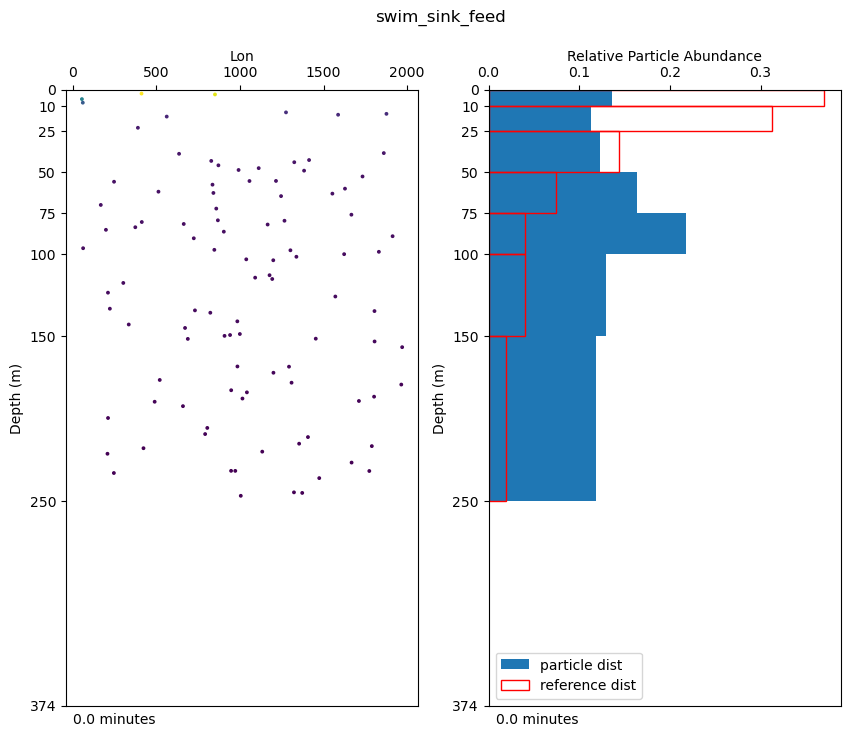

In [45]:
ss =[]
ani = anim(dat,fps=1)
f = '/ocean/mattmiller/MOAD/analysis-matt/notebooks/2D_model_iterations/'+iteration_name+'/'+iteration_name+'_swim_sink_feed.gif'
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

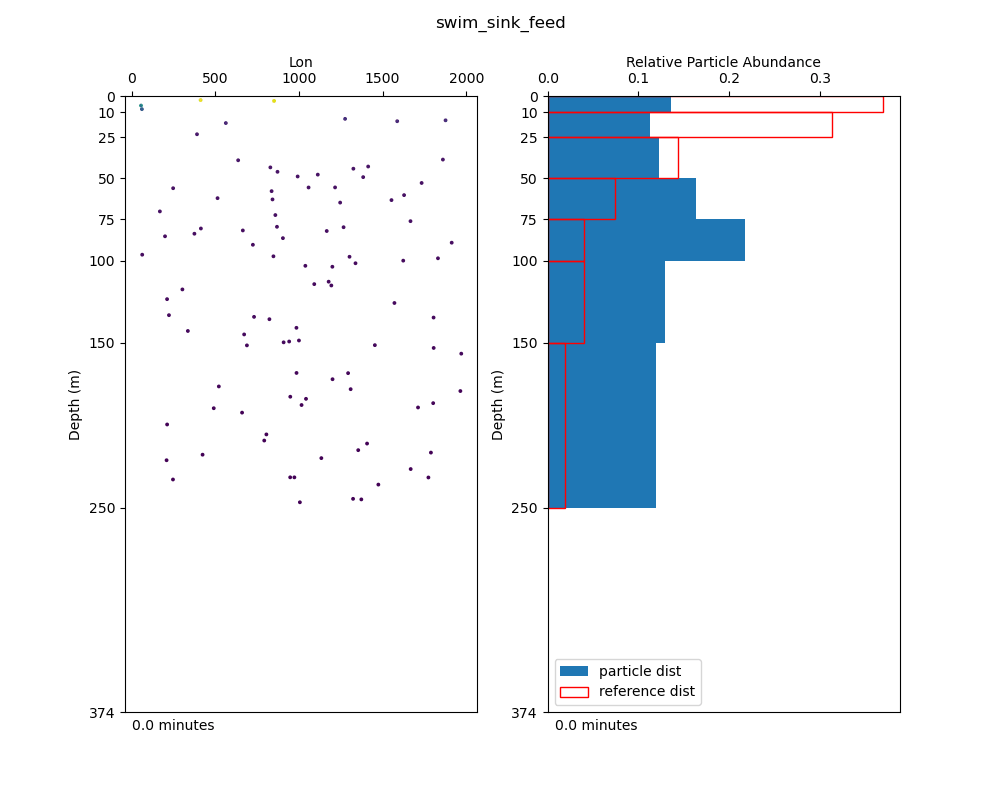

In [46]:
# swim_sink_feed - in just 6 hours they tend to sink more and the distribution tends to deepen
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

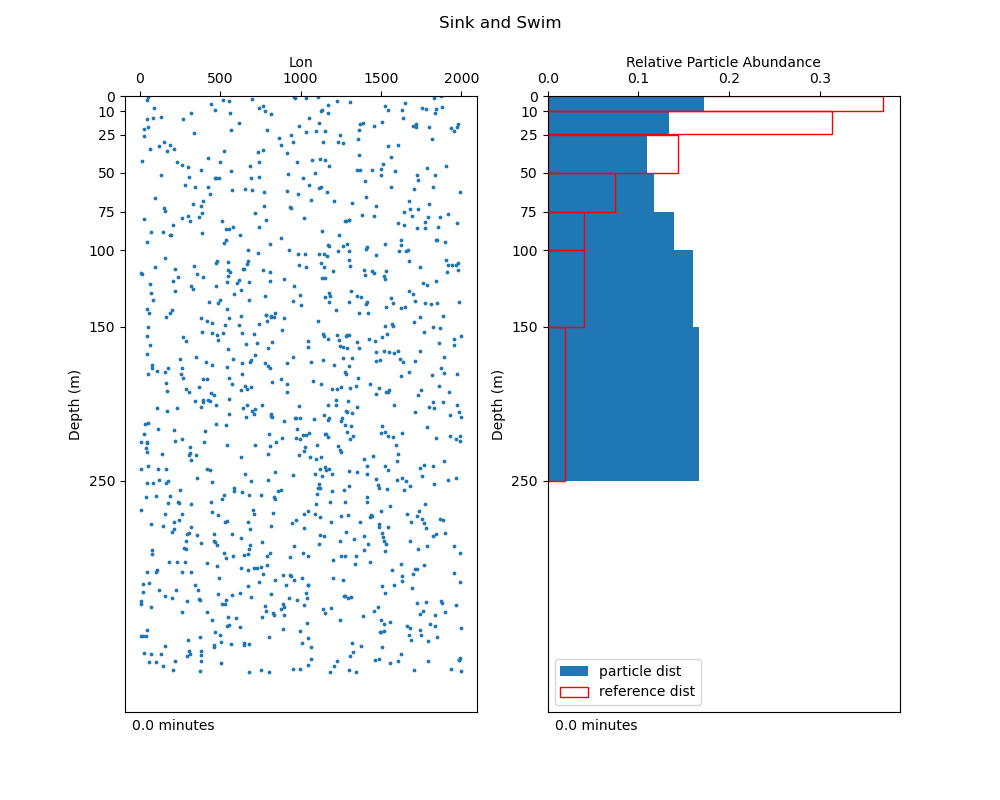

In [ ]:
# mix
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

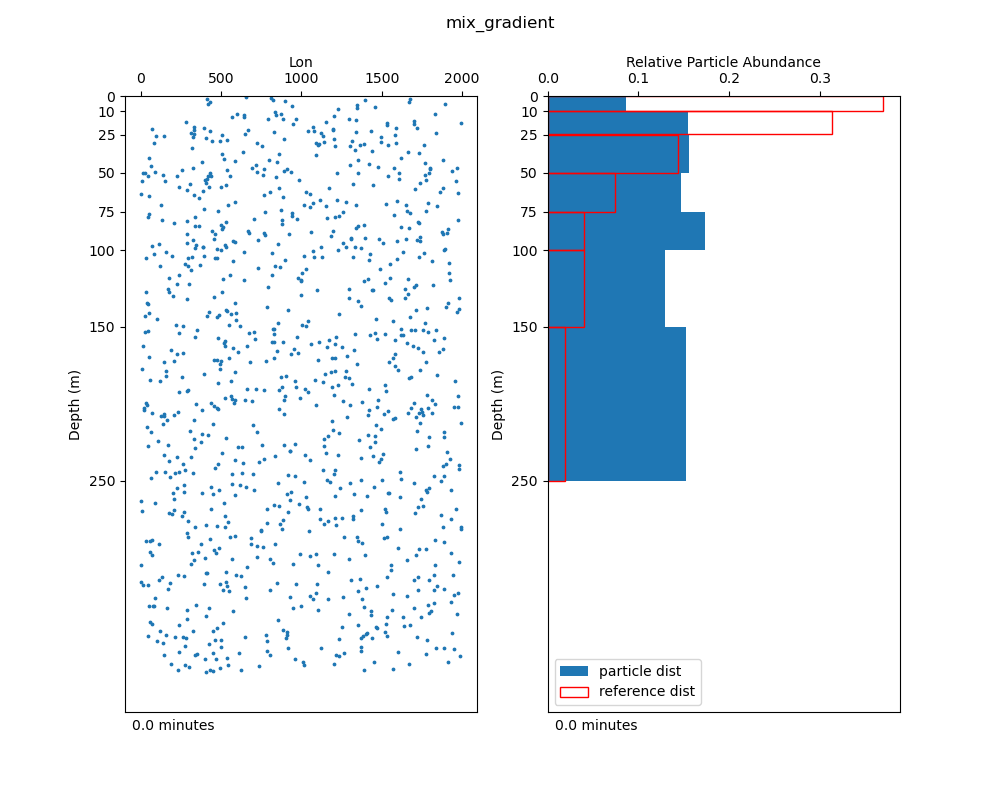

In [43]:
# mix_gradient
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [ ]:
# Appears to be very minimal difference over 1 hr between Jose's more comlex mixing kernel that includes surface mixed layer, bottom boundary layer, and a Kz gradient, and my simpler mixing kernel